In [9]:
import os, json, random, torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    DataCollatorForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback
)
from seqeval.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, classification_report
)
from sklearn.metrics import confusion_matrix

In [3]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
LOG_DIR = os.path.join(BASE_DIR, "logs")
OUTPUT_DIR = os.path.join(BASE_DIR, "models", "deid_finetuned")

TRAIN_FILE = os.path.join(DATA_DIR, "synthetic_train.jsonl")
VAL_FILE   = os.path.join(DATA_DIR, "synthetic_val.jsonl")
TEST_FILE  = os.path.join(DATA_DIR, "synthetic_test.jsonl")

MODEL_NAME = "StanfordAIMI/stanford-deidentifier-base"

EPOCHS = 4
BATCH_SIZE = 2
GRAD_ACCUM = 4
LR = 2e-5
MAX_LEN = 128
SEED = 42
SAVE_STEPS = 500 
random.seed(SEED)

In [4]:
os.environ["HF_DISABLE_PROGRESS_BARS"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================
# LABELS
# ============================================================
labels = ["O", "B-NAME", "B-LOCATION", "B-DATE", "B-CONTACT", "B-ID", "B-WEB"]
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}


In [5]:
def load_jsonl(path):
    entries = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            entries.append(json.loads(line))
    return entries

def label_sentence(entry):
    text = entry["text"]
    labs = ["O"] * len(text)
    for span in entry["spans"]:
        lab = span["label"].upper()
        if f"B-{lab}" not in labels:
            continue
        for i in range(span["start"], span["end"]):
            labs[i] = f"B-{lab}"
    return text, labs

def make_dataset(path):
    data = [label_sentence(e) for e in load_jsonl(path)]
    return Dataset.from_dict({"text": [t for t, _ in data], "labels": [l for _, l in data]})


In [6]:
train_ds = make_dataset(TRAIN_FILE)
val_ds   = make_dataset(VAL_FILE)
test_ds  = make_dataset(TEST_FILE)
print(f"📦 Loaded: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_and_align(batch):
    tokenized = tokenizer(
        batch["text"], truncation=True, padding="max_length",
        max_length=MAX_LEN, return_offsets_mapping=True
    )
    labels_out = []
    for i, offsets in enumerate(tokenized["offset_mapping"]):
        char_labels = batch["labels"][i]
        toks = []
        for start, end in offsets:
            if start == end:
                toks.append(-100)
            else:
                lab = char_labels[start] if start < len(char_labels) else "O"
                toks.append(label2id.get(lab, 0))
        labels_out.append(toks)
    tokenized["labels"] = labels_out
    tokenized.pop("offset_mapping")
    return tokenized

train_ds = train_ds.map(tokenize_and_align, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tokenize_and_align, batched=True, remove_columns=["text"])
test_ds  = test_ds.map(tokenize_and_align, batched=True, remove_columns=["text"])


📦 Loaded: Train=8176, Val=1022, Test=1022


Map:   0%|          | 0/8176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1022 [00:00<?, ? examples/s]

Map:   0%|          | 0/1022 [00:00<?, ? examples/s]

In [7]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"✅ Model loaded on: {device}")

data_collator = DataCollatorForTokenClassification(tokenizer)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at StanfordAIMI/stanford-deidentifier-base and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([8, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([8]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded on: cuda


In [15]:
def compute_metrics(p):
    preds, labs = p
    preds = preds.argmax(-1)

    # --- Prepare nested lists for seqeval ---
    true_labels = []
    pred_labels = []

    for pr, lb in zip(preds, labs):
        true_seq = []
        pred_seq = []
        for pi, li in zip(pr, lb):
            if li != -100:  # ignore padding tokens
                true_seq.append(id2label[li])
                pred_seq.append(id2label[pi])
        true_labels.append(true_seq)
        pred_labels.append(pred_seq)

    # --- Compute metrics using seqeval ---
    return {
        "precision": precision_score(true_labels, pred_labels),
        "recall": recall_score(true_labels, pred_labels),
        "f1": f1_score(true_labels, pred_labels),
        "accuracy": accuracy_score(true_labels, pred_labels),
    }


In [16]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=False,
    logging_dir=LOG_DIR,
    logging_strategy="steps",
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    eval_steps=SAVE_STEPS,      
    save_total_limit=5,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    max_grad_norm=1.0,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    fp16=torch.cuda.is_available(),
)

In [17]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3) 
    ]
)

In [18]:
checkpoint_dir = None
checkpoints = [d for d in os.listdir(OUTPUT_DIR) if d.startswith("checkpoint-")]

if checkpoints:
    # Find the latest checkpoint numerically (e.g., checkpoint-800 > checkpoint-600)
    latest_ckpt = max(checkpoints, key=lambda x: int(x.split("-")[-1]))
    checkpoint_dir = os.path.join(OUTPUT_DIR, latest_ckpt)
    print(f"🔁 Found existing checkpoint: {checkpoint_dir} — resuming training from last saved step.")

    with open(os.path.join(LOG_DIR, "train.log"), "a", encoding="utf-8") as log_file:
        print(f"🔁 Resuming training from checkpoint: {checkpoint_dir}\n", file=log_file)
        trainer.train(resume_from_checkpoint=checkpoint_dir)
        print("\n✅ Fine-tuning resumed and complete!", file=log_file)

else:
    print("🚀 No existing checkpoints found — starting fresh training.")
    with open(os.path.join(LOG_DIR, "train.log"), "a", encoding="utf-8") as log_file:
        print("🚀 Starting new training from scratch...\n", file=log_file)
        trainer.train()
        print("\n✅ Fine-tuning complete!", file=log_file)

# Save final model and tokenizer
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"✅ Model + tokenizer saved to {OUTPUT_DIR}")

🚀 No existing checkpoints found — starting fresh training.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.002900,0.000051,1.000000,1.000000,1.000000,1.000000
1000,0.000100,0.014816,0.991625,0.991625,0.991625,0.994502
1500,0.000600,0.000019,1.000000,1.000000,1.000000,1.000000
2000,0.000000,0.000014,1.000000,1.000000,1.000000,1.000000


✅ Model + tokenizer saved to d:\Projects\clinical deidentification\models\deid_finetuned


In [20]:
# -----------------------------------------------------------
# Final Evaluation on Test Set
# -----------------------------------------------------------
print("\n--- Evaluating on Test Set ---")
preds, labels, _ = trainer.predict(test_ds)
preds = np.argmax(preds, axis=-1)

true_tags, pred_tags = [], []

for p, l in zip(preds, labels):
    true_seq, pred_seq = [], []
    for pi, li in zip(p, l):
        if li != -100:
            true_seq.append(id2label[li])
            pred_seq.append(id2label[pi])
    true_tags.append(true_seq)
    pred_tags.append(pred_seq)

print("\nClassification Report (Test Set):")
print(classification_report(true_tags, pred_tags, digits=3))



--- Evaluating on Test Set ---



Classification Report (Test Set):
              precision    recall  f1-score   support

     CONTACT      1.000     1.000     1.000       757
        DATE      1.000     1.000     1.000       601
          ID      1.000     1.000     1.000      6897
    LOCATION      1.000     1.000     1.000      2533
        NAME      1.000     1.000     1.000      1016
         WEB      1.000     1.000     1.000      1120

   micro avg      1.000     1.000     1.000     12924
   macro avg      1.000     1.000     1.000     12924
weighted avg      1.000     1.000     1.000     12924



Labels present in test set: ['B-CONTACT', 'B-DATE', 'B-ID', 'B-LOCATION', 'B-NAME', 'B-WEB']


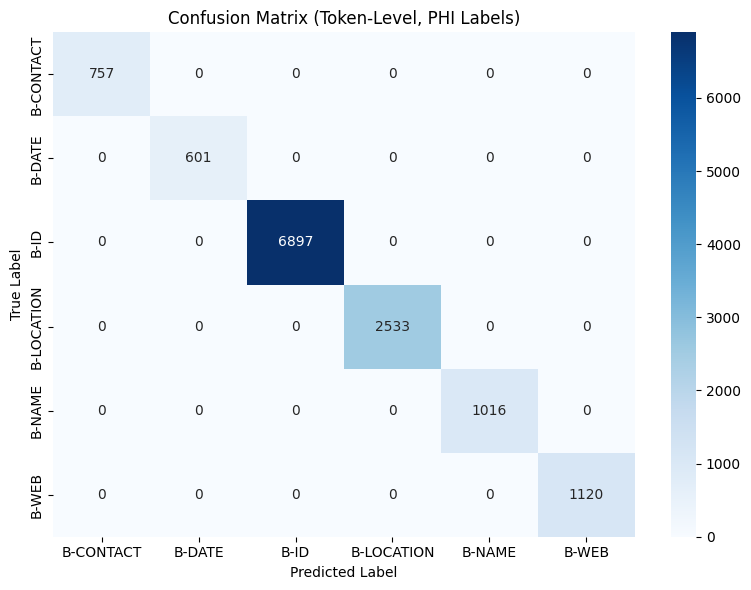

✅ Evaluation complete.


In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(true_tags, pred_tags, labels):
    # Flatten nested lists and remove non-PHI
    flat_true = [tag for seq in true_tags for tag in seq if tag != "O"]
    flat_pred = [tag for seq in pred_tags for tag in seq if tag != "O"]

    # Automatically detect which labels are actually present
    present_labels = sorted(set(flat_true) | set(flat_pred))
    print(f"Labels present in test set: {present_labels}")

    cm = confusion_matrix(flat_true, flat_pred, labels=present_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=present_labels,
        yticklabels=present_labels,
        cmap="Blues"
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Token-Level, PHI Labels)")
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(true_tags, pred_tags, labels=labels[1:])
print("✅ Evaluation complete.")